# Replication of De Bondt and Thaler (1985)

This notebook is adapted from code written by [Charles Martineau](http://www.charlesmartineau.com/) at the University of Toronto.
Prepared by [Vincent Grégoire](http://www.vincentgregoire.com), Department of Finance, The University of Melbourne. 

Objectives:

- Test for the overreaction hypothesis in financial markets based on 
  [De Bondt and Thaler (1985), Does the Stock Market Overreact?,
  Journal of Finance](http://onlinelibrary.wiley.com/doi/10.1111/j.1540-6261.1985.tb05004.x/full).
- Get similar results to Figure 3 in the paper.

Why:

- Research in experimental psychology has suggested that, in violation of
  Baye's rule, most people "overreact" to unexpected and dramatic news
  events. The question then arises whether such behavior matters at the
  market level.
  
This is not meant to be a perfect replication. In fact, I deliberately made different choices in the filtering (number of observations required, listing exchanges, etc.) and in the way to assess performance (computing abnormal returns, forming portfolios, etc.). The goal here is to replicate the spirit, and educate on how one can compute portfolio returns in Python.
 
This notebook was created as supplemental material to a Python for financial research workshop for finance honours and PhD students at the University of Melbourne in March of 2018.

Latest version: <https://github.com/vgreg/python-finance-unimelb2018>

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

## Step 1: load the CRSP monthly file

The CRSP monthly file is proprietary data and cannot be shared freely online, it will be distributed in class. For those trying to replicate this code with access to WRDS, the CRSP monthly file can be downloaded from WRDS using the web interface. Just make sure you get the same columns (PERMNO, SHRCD, EXCHCD, PRC, VOL, RET, SHROUT, vwretd, ewretd) and set the date format to something easy to parse as YYYY/MM/DD. We also pre-filtered the data to keep only common stock (SHRCD 10 or 11) listed on AMEX, NYSE or NASDAQ (EXCHCD 1, 2 or 3)

With pandas, there is little overhead in keeping CSV files in GZIP (compressed) format, so as a rule of thumb it is a practice I recommend, unless performance is really an issue.

In [2]:
df_crsp = pd.read_csv('crsp_monthly.csv.gz', nrows=100)  # Load part of the file to have a look

In [3]:
df_crsp.head()

,PERMNO,date,SHRCD,EXCHCD,PRC,VOL,RET,SHROUT,vwretd,ewretd
0,10000,1986/01/31,10,3,-4.37500,1771,C,3680,0.009829,0.044071
1,10000,1986/02/28,10,3,-3.25000,828,-0.257143,3680,0.072500,0.060381
2,10000,1986/03/31,10,3,-4.43750,1078,0.365385,3680,0.053885,0.047192
3,10000,1986/04/30,10,3,-4.00000,957,-0.098592,3793,-0.007903,0.016140
4,10000,1986/05/30,10,3,-3.10938,1074,-0.222656,3793,0.050844,0.036194


The WRDS files uses characters (letters such as `C`) to identify special cases. In our case we'll ignore these, but it's good practice to read the dataset documentation carefully to make sure that what you are doing is reasonable.

In this case, we reload the file, telling pandas to treat `C` as a null value. We also parse the dates.

In [4]:
df_crsp = pd.read_csv('crsp_monthly.csv.gz', na_values=['C'], parse_dates=['date'])

# The output from WRDS returns a mixed of small and large cap column names.
# We can easily convert everything to small caps.
cols = df_crsp.columns
df_crsp.columns = [c.lower() for c in cols]

In [5]:
df_crsp.head()

,permno,date,shrcd,exchcd,prc,vol,ret,shrout,vwretd,ewretd
0,10000,1986-01-31,10,3,-4.37500,1771.0,NaN,3680.0,0.009829,0.044071
1,10000,1986-02-28,10,3,-3.25000,828.0,-0.257143,3680.0,0.072500,0.060381
2,10000,1986-03-31,10,3,-4.43750,1078.0,0.365385,3680.0,0.053885,0.047192
3,10000,1986-04-30,10,3,-4.00000,957.0,-0.098592,3793.0,-0.007903,0.016140
4,10000,1986-05-30,10,3,-3.10938,1074.0,-0.222656,3793.0,0.050844,0.036194


In [6]:
df_crsp.tail()

,permno,date,shrcd,exchcd,prc,vol,ret,shrout,vwretd,ewretd
3457315,93436,2016-08-31,11,3,212.00999,622504.0,-0.097023,149239.0,0.002788,0.013066
3457316,93436,2016-09-30,11,3,204.03000,707217.0,-0.037640,149825.0,0.003016,0.015370
3457317,93436,2016-10-31,11,3,197.73000,922365.0,-0.030878,149891.0,-0.021589,-0.039935
3457318,93436,2016-11-30,11,3,189.39999,988496.0,-0.042128,149964.0,0.040416,0.050503
3457319,93436,2016-12-30,11,3,213.69000,879924.0,0.128247,149964.0,0.018779,0.015913


In [7]:
df_crsp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3457320 entries, 0 to 3457319
Data columns (total 10 columns):
permno    int64
date      datetime64[ns]
shrcd     int64
exchcd    int64
prc       float64
vol       float64
ret       float64
shrout    float64
vwretd    float64
ewretd    float64
dtypes: datetime64[ns](1), float64(6), int64(3)
memory usage: 263.8 MB


In [8]:
df_crsp.describe()

,permno,shrcd,exchcd,prc,vol,ret,shrout,vwretd,ewretd
count,3.457320e+06,3.457320e+06,3.457320e+06,3.417325e+06,3.147650e+06,3.391959e+06,3.453227e+06,3.457320e+06,3.457320e+06
mean,5.008518e+04,1.071646e+01,2.123415e+00,2.345021e+01,6.505134e+04,1.196887e-02,3.780344e+04,9.240308e-03,1.139583e-02
std,2.793295e+04,4.507153e-01,9.270400e-01,1.020640e+03,5.806065e+05,1.769483e-01,2.263616e+05,4.707374e-02,5.971679e-02
min,1.000000e+04,1.000000e+01,1.000000e+00,-1.832500e+03,0.000000e+00,-9.812950e-01,0.000000e+00,-2.917310e-01,-3.127530e-01
25%,2.228500e+04,1.000000e+01,1.000000e+00,1.500000e+00,4.340000e+02,-6.415100e-02,2.089000e+03,-1.771200e-02,-2.052300e-02
50%,4.915400e+04,1.100000e+01,2.000000e+00,1.050000e+01,2.596000e+03,0.000000e+00,6.359000e+03,1.274200e-02,1.419900e-02
75%,7.805000e+04,1.100000e+01,3.000000e+00,2.475000e+01,1.879600e+04,7.017500e-02,2.140400e+04,3.959900e-02,4.314500e-02
max,9.343600e+04,1.100000e+01,3.000000e+00,2.441210e+05,2.012427e+08,2.400000e+01,2.920640e+07,3.941430e-01,6.659360e-01


In [9]:
# Set the index (to select easily on date)
df_crsp = df_crsp.set_index('date')
df_crsp = df_crsp.sort_index()

In [10]:
# Some data cleaning

# We can drop SHRCD and EXCHCD, we already the filtering.
del df_crsp['shrcd']
del df_crsp['exchcd']
# Drop obs with missing returns
df_crsp = df_crsp[df_crsp.ret.notnull()]

# There are some negative number in the PRC column. Why is that? To find out, look at the doc!
# In our case, (in most cases actually), it's ok to just take the absolute value.
df_crsp['prc'] = np.abs(df_crsp['prc'])

In [11]:
# Compute continuously compounded returns (i.e. log returns).
# Why are these useful?
df_crsp['lret'] = np.log(1 + df_crsp['ret'])
df_crsp['lvwretd'] = np.log(1 + df_crsp['vwretd'])
df_crsp['lewretd'] = np.log(1 + df_crsp['ewretd'])

# Compute the market cap
df_crsp['size'] = df_crsp['shrout'] * df_crsp['prc']

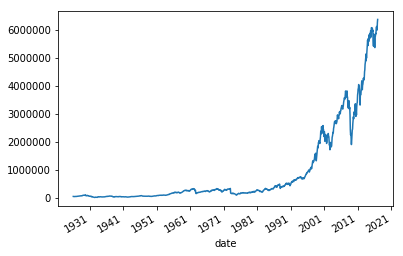

In [12]:
# Look at the average size over time
df_crsp.groupby(['date'])['size'].mean().plot()

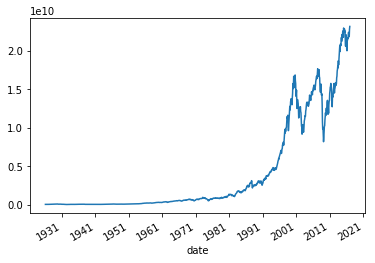

In [13]:
# Total market size over time

ax = df_crsp.groupby(['date'])['size'].sum().plot()

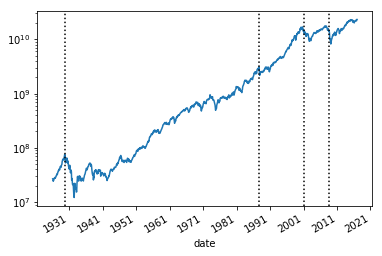

In [14]:
# More informative in logs!
ax = df_crsp.groupby(['date'])['size'].sum().plot(logy=True)

# Add some informative lines
ax.axvline(x=datetime(1929,10,24), color='k', linestyle=':') # Black Monday
ax.axvline(x=datetime(1987,10,19), color='k', linestyle=':') # Black Monday again
ax.axvline(x=datetime(2001,1,1), color='k', linestyle=':') # Tech bubble burst
ax.axvline(x=datetime(2008,9,16), color='k', linestyle=':')

## Step 2: analysis setup

In [15]:
# Parameters
form_period = 36 # Formation period, in month
hold_period = 36 # Holding period, in months
use_deciles = True # Use deciles to form the top and bottom portfolio
n_stocks = 35  # Number of stocks in the top and bottom performance (if not using top and bottom deciles)
start_date = '1935-01-01'
end_date = '2014-01-01'
benchmark = 'vwretd' # Benchmark market return to use ('vwretd' or 'ewretd')

In [16]:
# Get the dates of portfolio formation.
# The frequency tells how far appart to put the dates.
# 'M' stand for month, 'MS' is for month start, to make sure we 
# have first day of the month. It needs to be a string, so we convert
# our numbers to string. Note: you can also keep floats and use pandas
# date offsets.
dates = pd.date_range(start=start_date, end=end_date, freq=str(np.int(form_period)) + 'MS')
dates

DatetimeIndex(['1935-01-01', '1938-01-01', '1941-01-01', '1944-01-01',
               '1947-01-01', '1950-01-01', '1953-01-01', '1956-01-01',
               '1959-01-01', '1962-01-01', '1965-01-01', '1968-01-01',
               '1971-01-01', '1974-01-01', '1977-01-01', '1980-01-01',
               '1983-01-01', '1986-01-01', '1989-01-01', '1992-01-01',
               '1995-01-01', '1998-01-01', '2001-01-01', '2004-01-01',
               '2007-01-01', '2010-01-01', '2013-01-01'],
              dtype='datetime64[ns]', freq='36MS')

## Step 3: forming portfolios

In this step, we want to create the portfolios at each portfolio formation date. Basically, we want to evaluate each stock's performance in the formation period prior to the formation date, and form portfolios (groups of stocks) based on past performance.

For simplicity, at each date we only keep track of the top and bottom portfolios.

In [17]:
# Let's first do it for only one date.
date = dates[0]

beg_dt = date - pd.offsets.MonthBegin(1) * form_period

# Select obs for the formation period
crsp_t = df_crsp[beg_dt:date.to_pydatetime()].copy()

In [18]:
crsp_t.describe()

,permno,prc,vol,ret,shrout,vwretd,ewretd,lret,lvwretd,lewretd,size
count,24722.000000,24722.000000,24722.000000,24722.000000,24722.000000,24722.000000,24722.000000,24722.000000,24722.000000,24722.000000,2.472200e+04
mean,15114.583650,17.546209,512.641129,0.051037,1615.700995,0.019848,0.050994,0.013141,0.010978,0.031861,3.367911e+04
std,4179.764387,25.273394,1459.049971,0.325586,3699.231224,0.138872,0.212484,0.260388,0.129815,0.183346,1.169322e+05
min,10006.000000,0.125000,0.000000,-0.857143,14.000000,-0.206198,-0.202303,-1.945911,-0.230921,-0.226026,7.500000e+00
25%,12394.000000,3.875000,18.000000,-0.113985,276.000000,-0.072273,-0.107240,-0.121022,-0.075018,-0.113437,1.555922e+03
50%,14875.000000,9.500000,82.000000,0.000000,560.000000,-0.002362,0.008062,0.000000,-0.002365,0.008030,5.126750e+03
75%,17427.000000,22.000000,363.000000,0.125000,1399.000000,0.057663,0.098561,0.117783,0.056062,0.094001,2.207316e+04
max,75471.000000,567.500000,38270.000000,5.888889,43500.000000,0.394143,0.665936,1.929910,0.332280,0.510387,2.377072e+06


In [19]:
crsp_t.head()

,permno,prc,vol,ret,shrout,vwretd,ewretd,lret,lvwretd,lewretd,size
date,,,,,,,,,,,
1932-01-30,14453,0.375,99.0,-0.538462,135.0,-0.010534,0.08592,-0.773191,-0.01059,0.082428,50.625
1932-01-30,14322,32.375,1304.0,0.000000,4921.0,-0.010534,0.08592,0.000000,-0.01059,0.082428,159317.375
1932-01-30,17478,6.500,10.0,-0.525114,600.0,-0.010534,0.08592,-0.744681,-0.01059,0.082428,3900.000
1932-01-30,12140,4.125,208.0,0.031250,1167.0,-0.010534,0.08592,0.030772,-0.01059,0.082428,4813.875
1932-01-30,12052,2.250,227.0,1.571429,776.0,-0.010534,0.08592,0.944462,-0.01059,0.082428,1746.000


In [20]:
crsp_t.tail()

,permno,prc,vol,ret,shrout,vwretd,ewretd,lret,lvwretd,lewretd,size
date,,,,,,,,,,,
1934-12-31,15499,20.75,280.0,0.057325,1181.0,0.003554,0.014735,0.055742,0.003548,0.014627,24505.75
1934-12-31,13426,13.00,0.0,-0.023474,150.0,0.003554,0.014735,-0.023754,0.003548,0.014627,1950.00
1934-12-31,12749,21.75,577.0,0.053892,5518.0,0.003554,0.014735,0.052490,0.003548,0.014627,120016.50
1934-12-31,12618,7.25,9.0,0.094340,222.0,0.003554,0.014735,0.090151,0.003548,0.014627,1609.50
1934-12-31,18219,5.75,204.0,0.095238,900.0,0.003554,0.014735,0.090972,0.003548,0.014627,5175.00


In [21]:
# We only want to keep stocks that are there during the full formation window

crsp_t['N'] = crsp_t.groupby(['permno'])['permno'].transform('count')

# Filter on number of observations. We only keep sotcks for which we have returns
# over the full observation period.
crsp_t = crsp_t[crsp_t['N'] >= form_period]


In [22]:
crsp_t.describe()

,permno,prc,vol,ret,shrout,vwretd,ewretd,lret,lvwretd,lewretd,size,N
count,20772.000000,20772.000000,20772.000000,20772.000000,20772.000000,20772.000000,20772.000000,20772.000000,20772.000000,20772.000000,2.077200e+04,20772.0
mean,14884.762565,17.263076,583.356586,0.050523,1801.411660,0.020051,0.051258,0.014317,0.011174,0.032089,3.797881e+04,36.0
std,3528.965895,22.789266,1566.212628,0.316315,3990.154553,0.138918,0.212645,0.254017,0.129850,0.183484,1.266116e+05,0.0
min,10006.000000,0.187500,0.000000,-0.789474,32.000000,-0.206198,-0.202303,-1.558146,-0.230921,-0.226026,1.856250e+01,36.0
25%,12335.000000,4.000000,27.000000,-0.114524,300.000000,-0.075117,-0.096123,-0.121630,-0.078103,-0.101087,1.713859e+03,36.0
50%,14699.000000,9.750000,109.000000,0.000000,626.000000,0.000596,0.009462,0.000000,0.000591,0.009417,5.796875e+03,36.0
75%,17208.000000,21.875000,449.000000,0.126691,1543.000000,0.063771,0.098951,0.119285,0.061771,0.094356,2.582194e+04,36.0
max,58368.000000,415.000000,38270.000000,5.888889,43500.000000,0.394143,0.665936,1.929910,0.332280,0.510387,2.377072e+06,36.0


In [23]:
# Now for each stock we want to compute the full period return. Easy with log returns, just sum up!
stock_ret = crsp_t.groupby('permno')['lret', 'lvwretd', 'lewretd'].sum()

In [24]:
stock_ret.head()

,lret,lvwretd,lewretd
permno,,,
10006,1.008231,0.402266,1.155207
10014,0.417169,0.402266,1.155207
10030,0.834746,0.402266,1.155207
10057,0.875466,0.402266,1.155207
10073,0.890317,0.402266,1.155207


In [25]:
# Next compute excess returns based on the chosen index.
# Note that since the benchmark is the same for all stocks, we could use
# actual returns for ranking purposes. It would only make a difference in some
# cases. Which ones?

stock_ret['lexret'] = stock_ret['lret'] - stock_ret['l' + benchmark]

In [26]:
# Now deciles and rankings.

stock_ret['decile'] = pd.qcut(stock_ret['lexret'], 10, labels=False) # (0=worst, 9=best)
stock_ret['rank_asc'] = stock_ret['lexret'].rank() # (1 = worst return)
stock_ret['rank_inv'] = stock_ret['lexret'].rank(ascending=False) # (1= best return)

In [27]:
# Assign stock to top or bottom portfolio

if use_deciles:
    top_ptf = stock_ret[stock_ret.decile == 9].reset_index()[['permno', 'lexret']]
    bot_ptf = stock_ret[stock_ret.decile == 0].reset_index()[['permno', 'lexret']]
else:
    top_ptf = stock_ret[stock_ret.rank_inv <= n_stocks].reset_index()[['permno', 'lexret']]
    bot_ptf = stock_ret[stock_ret.rank_asc <= n_stocks].reset_index()[['permno', 'lexret']]
    

In [28]:
top_ptf.head()

,permno,lexret
0,10276,2.236791
1,10399,0.984027
2,10444,1.175686
3,10460,1.120160
4,10516,1.004986


In [29]:
bot_ptf.head()

,permno,lexret
0,10137,-0.856036
1,10196,-0.872267
2,10268,-1.669711
3,10612,-1.080301
4,10962,-1.331802


Now that we have the code working for one date, we need to run it on each date. Now it's time to make it a function.

In [30]:
def compute_performance_portfolios(date, df, form_period=36, use_deciles=True, n_stocks=35,
                                   benchmark='vwretd'):
    beg_dt = date - pd.offsets.MonthBegin(1) * form_period

    # Select obs for the formation period
    crsp_t = df[beg_dt:date.to_pydatetime()].copy()
    
    # We only want to keep stocks that are there during the full formation window
    crsp_t['N'] = crsp_t.groupby(['permno'])['permno'].transform('count')
    # Filter on number of observations. We only keep sotcks for which we have returns
    # over the full observation period.
    crsp_t = crsp_t[crsp_t['N'] >= form_period]
    
    # Now for each stock we want to compute the full period return. Easy with log returns, just sum up!
    stock_ret = crsp_t.groupby('permno')['lret', 'lvwretd', 'lewretd'].sum()# Next compute excess returns based on the chosen index.
    # Compute excess returns
    stock_ret['lexret'] = stock_ret['lret'] - stock_ret['l' + benchmark]
    # Now deciles and rankings.
    stock_ret['decile'] = pd.qcut(stock_ret['lexret'], 10, labels=False) # (0=worst, 9=best)
    stock_ret['rank_asc'] = stock_ret['lexret'].rank() # (1 = worst return)
    stock_ret['rank_inv'] = stock_ret['lexret'].rank(ascending=False) # (1= best return)
    # Assign stock to top or bottom portfolio
    if use_deciles:
        top_ptf = stock_ret[stock_ret.decile == 9].reset_index()[['permno', 'lexret']]
        bot_ptf = stock_ret[stock_ret.decile == 0].reset_index()[['permno', 'lexret']]
    else:
        top_ptf = stock_ret[stock_ret.rank_inv <= n_stocks].reset_index()[['permno', 'lexret']]
        bot_ptf = stock_ret[stock_ret.rank_asc <= n_stocks].reset_index()[['permno', 'lexret']]
    
    return (bot_ptf, top_ptf)

In [31]:
portfolios = {}
for date in dates:
    portfolios[date] = compute_performance_portfolios(date, df_crsp, use_deciles=False, benchmark='vwretd')

In [32]:
portfolios[date][0].head()

,permno,lexret
0,18148,-3.807226
1,59483,-7.137162
2,64864,-3.243800
3,77175,-3.046573
4,79516,-4.233192


## Step 3: holding period returns

Next, we want to compute cumulative abnormal returns for portfolios during the holding period. We will use the same approach, i.e. do it for one portfolio/date, then package it as a function.

In [33]:
date = dates[0]
ptf = portfolios[date][0] # Bottom portfolio.

benchmark = 'vwretd'
weighting = 'vw' # 'vw' or 'ew'


In [34]:
ptf = ptf.copy()
end_dt = date + pd.offsets.MonthBegin(1) * hold_period

# Select obs for the formation period
crsp_t2 = df_crsp[date.to_pydatetime():end_dt].copy()

In [35]:
# Merge with stocks in portfolios, to keep only those stocks
crsp_t2 = pd.merge(crsp_t2.reset_index(), ptf, on=['permno'])

In [36]:
crsp_t2.head()

,date,permno,prc,vol,ret,shrout,vwretd,ewretd,lret,lvwretd,lewretd,size,lexret
0,1935-01-31,14816,4.4375,10.0,-0.112500,82.0,-0.033416,-0.029663,-0.119347,-0.033987,-0.030112,363.875,-1.328398
1,1935-02-28,14816,3.6875,2.0,-0.169014,82.0,-0.019462,-0.056016,-0.185142,-0.019654,-0.057646,302.375,-1.328398
2,1935-03-30,14816,4.1875,13.0,0.135593,82.0,-0.036013,-0.073353,0.127155,-0.036677,-0.076183,343.375,-1.328398
3,1935-04-30,14816,3.7500,1.0,-0.104478,82.0,0.090452,0.101628,-0.110348,0.086592,0.096789,307.500,-1.328398
4,1935-05-31,14816,4.3750,18.0,0.166667,82.0,0.034561,0.024401,0.154151,0.033977,0.024108,358.750,-1.328398


In [37]:
crsp_t2.tail()

,date,permno,prc,vol,ret,shrout,vwretd,ewretd,lret,lvwretd,lewretd,size,lexret
1166,1937-08-31,14568,8.000,228.0,-0.179487,2163.0,-0.048365,-0.052749,-0.197826,-0.049574,-0.054191,17304.000,-2.058876
1167,1937-09-30,14568,5.875,752.0,-0.265625,2163.0,-0.136623,-0.193182,-0.308735,-0.146904,-0.214657,12707.625,-2.058876
1168,1937-10-30,14568,6.000,1227.0,0.021277,2163.0,-0.095798,-0.101549,0.021054,-0.100702,-0.107083,12978.000,-2.058876
1169,1937-11-30,14568,5.625,691.0,-0.062500,2163.0,-0.083053,-0.108639,-0.064539,-0.086706,-0.115006,12166.875,-2.058876
1170,1937-12-31,14568,4.250,426.0,-0.244444,2163.0,-0.040774,-0.099215,-0.280301,-0.041629,-0.104489,9192.750,-2.058876


In [38]:
crsp_t2.tail()

,date,permno,prc,vol,ret,shrout,vwretd,ewretd,lret,lvwretd,lewretd,size,lexret
1166,1937-08-31,14568,8.000,228.0,-0.179487,2163.0,-0.048365,-0.052749,-0.197826,-0.049574,-0.054191,17304.000,-2.058876
1167,1937-09-30,14568,5.875,752.0,-0.265625,2163.0,-0.136623,-0.193182,-0.308735,-0.146904,-0.214657,12707.625,-2.058876
1168,1937-10-30,14568,6.000,1227.0,0.021277,2163.0,-0.095798,-0.101549,0.021054,-0.100702,-0.107083,12978.000,-2.058876
1169,1937-11-30,14568,5.625,691.0,-0.062500,2163.0,-0.083053,-0.108639,-0.064539,-0.086706,-0.115006,12166.875,-2.058876
1170,1937-12-31,14568,4.250,426.0,-0.244444,2163.0,-0.040774,-0.099215,-0.280301,-0.041629,-0.104489,9192.750,-2.058876


In [39]:
# We want to make sure we have one observation for each stock/date.
# If a stock is delisted, its returns will be 0 after it disappears,
# so we just fill in these missing values.
# Note that here we're simplifying a bit. CRSP does include delisting
# returns that we should have added as well, but we didn't.

# The idea here is to create a DataFrame with all the permno/date pairs
# that we want in the final dataset. Then we merge that list with the
# dataset using "outer" which will generate missing values for the
# pairs that are not in the dataset.

# Get the dates in the dataset.
pairs_t2 = [{'date': d, 'permno': p} for d in crsp_t2['date'].unique() 
                                    for p in ptf['permno'].unique()]
pairs_t2[:10]

[{'date': numpy.datetime64('1935-01-31T00:00:00.000000000'), 'permno': 10268},
 {'date': numpy.datetime64('1935-01-31T00:00:00.000000000'), 'permno': 10962},
 {'date': numpy.datetime64('1935-01-31T00:00:00.000000000'), 'permno': 11252},
 {'date': numpy.datetime64('1935-01-31T00:00:00.000000000'), 'permno': 11391},
 {'date': numpy.datetime64('1935-01-31T00:00:00.000000000'), 'permno': 11404},
 {'date': numpy.datetime64('1935-01-31T00:00:00.000000000'), 'permno': 11789},
 {'date': numpy.datetime64('1935-01-31T00:00:00.000000000'), 'permno': 11842},
 {'date': numpy.datetime64('1935-01-31T00:00:00.000000000'), 'permno': 11906},
 {'date': numpy.datetime64('1935-01-31T00:00:00.000000000'), 'permno': 12351},
 {'date': numpy.datetime64('1935-01-31T00:00:00.000000000'), 'permno': 13215}]

In [40]:
pairs_t2 = pd.DataFrame(pairs_t2)
pairs_t2.head()

,date,permno
0,1935-01-31,10268
1,1935-01-31,10962
2,1935-01-31,11252
3,1935-01-31,11391
4,1935-01-31,11404


In [41]:
crsp_t2.describe()

,permno,prc,vol,ret,shrout,vwretd,ewretd,lret,lvwretd,lewretd,size,lexret
count,1171.000000,1171.000000,1171.000000,1171.000000,1171.000000,1171.000000,1171.000000,1171.000000,1171.000000,1171.000000,1171.00000,1171.000000
mean,15076.396243,11.017400,617.359522,0.021253,2694.972673,0.008464,0.011984,-0.000408,0.006866,0.008591,26332.46867,-1.544866
std,2704.006430,11.516107,1405.983849,0.229681,6307.286717,0.055597,0.081141,0.202106,0.056330,0.082274,69787.98260,0.357163
min,10268.000000,0.250000,0.000000,-0.629630,70.000000,-0.136623,-0.193182,-0.993253,-0.146904,-0.214657,80.06250,-2.419799
25%,12351.000000,3.000000,39.000000,-0.107143,355.000000,-0.033416,-0.052749,-0.113329,-0.033987,-0.054191,1440.09375,-1.845714
50%,14816.000000,6.625000,125.000000,-0.012821,676.000000,0.024671,0.024401,-0.012904,0.024372,0.024108,4686.00000,-1.416882
75%,17945.000000,15.625000,441.000000,0.105787,1910.000000,0.052872,0.081930,0.100557,0.051522,0.078746,16763.25000,-1.266480
max,18892.000000,63.500000,17785.000000,2.000000,33673.000000,0.090452,0.150165,1.098612,0.086592,0.139905,549461.37500,-1.084910


In [42]:
# Merge to generate placeholders

crsp_t2 = pd.merge(crsp_t2, pairs_t2, how='outer',
                   on=['permno', 'date'])
crsp_t2.describe()

,permno,prc,vol,ret,shrout,vwretd,ewretd,lret,lvwretd,lewretd,size,lexret
count,1260.000000,1171.000000,1171.000000,1171.000000,1171.000000,1171.000000,1171.000000,1171.000000,1171.000000,1171.000000,1171.00000,1171.000000
mean,15027.057143,11.017400,617.359522,0.021253,2694.972673,0.008464,0.011984,-0.000408,0.006866,0.008591,26332.46867,-1.544866
std,2678.672301,11.516107,1405.983849,0.229681,6307.286717,0.055597,0.081141,0.202106,0.056330,0.082274,69787.98260,0.357163
min,10268.000000,0.250000,0.000000,-0.629630,70.000000,-0.136623,-0.193182,-0.993253,-0.146904,-0.214657,80.06250,-2.419799
25%,12351.000000,3.000000,39.000000,-0.107143,355.000000,-0.033416,-0.052749,-0.113329,-0.033987,-0.054191,1440.09375,-1.845714
50%,14816.000000,6.625000,125.000000,-0.012821,676.000000,0.024671,0.024401,-0.012904,0.024372,0.024108,4686.00000,-1.416882
75%,17945.000000,15.625000,441.000000,0.105787,1910.000000,0.052872,0.081930,0.100557,0.051522,0.078746,16763.25000,-1.266480
max,18892.000000,63.500000,17785.000000,2.000000,33673.000000,0.090452,0.150165,1.098612,0.086592,0.139905,549461.37500,-1.084910


In [43]:
ret_cols = ['ret', 'vwretd', 'ewretd', 'lvwretd','lewretd', 'lret', 'lexret']
crsp_t2[ret_cols] = crsp_t2[ret_cols].fillna(0.0)

In [44]:
crsp_t2.describe()

,permno,prc,vol,ret,shrout,vwretd,ewretd,lret,lvwretd,lewretd,size,lexret
count,1260.000000,1171.000000,1171.000000,1260.000000,1171.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1171.00000,1260.000000
mean,15027.057143,11.017400,617.359522,0.019752,2694.972673,0.007866,0.011138,-0.000379,0.006381,0.007984,26332.46867,-1.435744
std,2678.672301,11.516107,1405.983849,0.221481,6307.286717,0.053640,0.078280,0.194832,0.054331,0.079343,69787.98260,0.524731
min,10268.000000,0.250000,0.000000,-0.629630,70.000000,-0.136623,-0.193182,-0.993253,-0.146904,-0.214657,80.06250,-2.419799
25%,12351.000000,3.000000,39.000000,-0.099921,355.000000,-0.033416,-0.052749,-0.105273,-0.033987,-0.054191,1440.09375,-1.788559
50%,14816.000000,6.625000,125.000000,0.000000,676.000000,0.011899,0.023798,0.000000,0.011829,0.023519,4686.00000,-1.413128
75%,17945.000000,15.625000,441.000000,0.090909,1910.000000,0.052043,0.076221,0.087011,0.050734,0.073456,16763.25000,-1.227762
max,18892.000000,63.500000,17785.000000,2.000000,33673.000000,0.090452,0.150165,1.098612,0.086592,0.139905,549461.37500,0.000000


In [45]:
# Now we want the return up to each point in time
crsp_t2['lcumret'] = crsp_t2.groupby('permno')['lret'].cumsum()
crsp_t2['lcum' + benchmark] = crsp_t2.groupby('permno')['l' + benchmark].cumsum()

In [46]:
# At each point in time, the return of the portfolio will be the 
# cumulative return of each component weighted by the initial weight.
# Note that here we need the simple return average, not log return.
crsp_t2['cumret'] = np.exp(crsp_t2['lcumret']) - 1
crsp_t2['cum' + benchmark] = np.exp(crsp_t2['lcum' + benchmark]) - 1

# Add weights, equal weighted is easy.
ptf['ew'] = 1 / len(ptf)

# For value-weighted, need to get size as of formation date.
ptf['date'] = date
weights = pd.merge_asof(ptf, df_crsp[['permno', 'size']],
                        by='permno',
                        left_on='date',
                        right_index=True)
weights['vw'] = weights['size'] / weights['size'].sum()

del weights['lexret']
del weights['date']
del weights['size']

In [47]:
weights.head()

,permno,ew,vw
0,10268,0.028571,0.004188
1,10962,0.028571,0.000733
2,11252,0.028571,0.003378
3,11391,0.028571,0.005008
4,11404,0.028571,0.496579


In [48]:
# Now merge back with returns
crsp_t2 = pd.merge(crsp_t2, weights, on='permno')

In [49]:
crsp_t2.head()

,date,permno,prc,vol,ret,shrout,vwretd,ewretd,lret,lvwretd,lewretd,size,lexret,lcumret,lcumvwretd,cumret,cumvwretd,ew,vw
0,1935-01-31,14816,4.4375,10.0,-0.112500,82.0,-0.033416,-0.029663,-0.119347,-0.033987,-0.030112,363.875,-1.328398,-0.119347,-0.033987,-0.1125,-0.033416,0.028571,0.000876
1,1935-02-28,14816,3.6875,2.0,-0.169014,82.0,-0.019462,-0.056016,-0.185142,-0.019654,-0.057646,302.375,-1.328398,-0.304489,-0.053641,-0.2625,-0.052228,0.028571,0.000876
2,1935-03-30,14816,4.1875,13.0,0.135593,82.0,-0.036013,-0.073353,0.127155,-0.036677,-0.076183,343.375,-1.328398,-0.177334,-0.090318,-0.1625,-0.086360,0.028571,0.000876
3,1935-04-30,14816,3.7500,1.0,-0.104478,82.0,0.090452,0.101628,-0.110348,0.086592,0.096789,307.500,-1.328398,-0.287683,-0.003726,-0.2500,-0.003719,0.028571,0.000876
4,1935-05-31,14816,4.3750,18.0,0.166667,82.0,0.034561,0.024401,0.154151,0.033977,0.024108,358.750,-1.328398,-0.133532,0.030251,-0.1250,0.030713,0.028571,0.000876


In [50]:
# Now compute the weighted cumulative return
crsp_t2['wcumret'] = crsp_t2[weighting] * crsp_t2['cumret']
crsp_t2['wcum' + benchmark] = crsp_t2[weighting] * crsp_t2['cum' + benchmark]

ptf_ret = crsp_t2.groupby(['date'])[['wcumret', 'wcum' + benchmark]].sum()

In [51]:
# Count the months
ptf_ret = ptf_ret.reset_index()
ptf_ret['months'] = ptf_ret.index.values + 1

In [52]:
ptf_ret['exret'] = ptf_ret['wcumret'] - ptf_ret['wcum' + benchmark]

In [53]:
ptf_ret.head()

,date,wcumret,wcumvwretd,months,exret
0,1935-01-31,-0.036804,-0.033416,1,-0.003388
1,1935-02-28,-0.139372,-0.051629,2,-0.087743
2,1935-03-30,-0.054903,-0.083411,3,0.028508
3,1935-04-30,0.041403,-0.003807,4,0.045210
4,1935-05-31,0.168925,0.031179,5,0.137746


Ok, looks like we're ready to package as a function.

In [54]:
def compute_holding_returns(date, ptf, df, benchmark='vwretd', weighting='vw', hold_per=36):
    ptf = ptf.copy()
    end_dt = date + pd.offsets.MonthBegin(1) * hold_period
    # Select obs for the formation period
    crsp_t2 = df[date.to_pydatetime():end_dt].copy()
    # Merge with stocks in portfolios, to keep only those stocks
    crsp_t2 = pd.merge(crsp_t2.reset_index(), ptf, on=['permno'])
    

    # Get the dates in the dataset.
    pairs_t2 = [{'date': d, 'permno': p} for d in crsp_t2['date'].unique() 
                                        for p in ptf['permno'].unique()]
    pairs_t2 = pd.DataFrame(pairs_t2)
    crsp_t2 = pd.merge(crsp_t2, pairs_t2, how='outer',
                   on=['permno', 'date'])
    ret_cols = ['ret', 'vwretd', 'ewretd', 'lvwretd','lewretd', 'lret', 'lexret']
    crsp_t2[ret_cols] = crsp_t2[ret_cols].fillna(0.0)
    
    # Now we want the return up to each point in time
    crsp_t2['lcumret'] = crsp_t2.groupby('permno')['lret'].cumsum()
    crsp_t2['lcum' + benchmark] = crsp_t2.groupby('permno')['l' + benchmark].cumsum()

    # At each point in time, the return of the portfolio will be the 
    # cumulative return of each component weighted by the initial weight.
    # Note that here we need the simple return average, not log return.
    crsp_t2['cumret'] = np.exp(crsp_t2['lcumret']) - 1
    crsp_t2['cum' + benchmark] = np.exp(crsp_t2['lcum' + benchmark]) - 1

    # Add weights, equal weighted is easy.
    ptf['ew'] = 1 / len(ptf)

    # For value-weighted, need to get size as of formation date.
    ptf['date'] = date
    weights = pd.merge_asof(ptf, df_crsp[['permno', 'size']],
                            by='permno',
                            left_on='date',
                            right_index=True)
    weights['vw'] = weights['size'] / weights['size'].sum()

    del weights['lexret']
    del weights['date']
    del weights['size']
    
    # Now merge back with returns
    crsp_t2 = pd.merge(crsp_t2, weights, on='permno')
    
    # Now compute the weighted cumulative return
    crsp_t2['wcumret'] = crsp_t2[weighting] * crsp_t2['cumret']
    crsp_t2['wcum' + benchmark] = crsp_t2[weighting] * crsp_t2['cum' + benchmark]

    ptf_ret = crsp_t2.groupby(['date'])[['wcumret', 'wcum' + benchmark]].sum()
    
    # Count the months
    ptf_ret = ptf_ret.reset_index()
    ptf_ret['months'] = ptf_ret.index.values + 1
    
    ptf_ret['exret'] = ptf_ret['wcumret'] - ptf_ret['wcum' + benchmark]
    
    return ptf_ret

In [55]:
bot_ptf_ret = []
top_ptf_ret = []

for date in dates:
    bot_ptf_ret.append(compute_holding_returns(date, portfolios[date][0], df_crsp,
                                               benchmark='vwretd', weighting='vw'))
    top_ptf_ret.append(compute_holding_returns(date, portfolios[date][1], df_crsp,
                                               benchmark='vwretd', weighting='vw'))
    
bot_ptf_ret = pd.concat(bot_ptf_ret)
top_ptf_ret = pd.concat(top_ptf_ret)

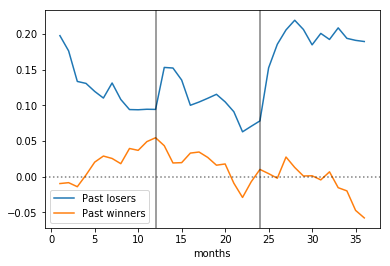

In [56]:
ax = bot_ptf_ret.groupby('months')['exret'].mean().plot(label='Past losers')
top_ptf_ret.groupby('months')['exret'].mean().plot(ax=ax, label='Past winners')
ax.legend()
ax.axhline(y=0, color='black', alpha=0.5, linestyle=':')
ax.axvline(x=12, color='black', alpha=0.5, linestyle='-')
ax.axvline(x=24, color='black', alpha=0.5, linestyle='-')

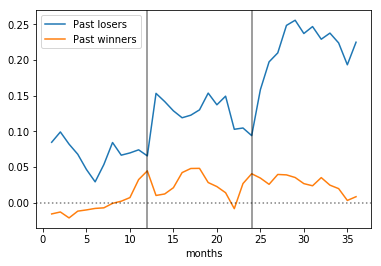

In [57]:
# Only pre 1980
ax = bot_ptf_ret.set_index('date')[:'1980'].groupby('months')['exret'].mean().plot(label='Past losers')
top_ptf_ret.set_index('date')[:'1980'].groupby('months')['exret'].mean().plot(ax=ax, label='Past winners')
ax.legend()
ax.axhline(y=0, color='black', alpha=0.5, linestyle=':')
ax.axvline(x=12, color='black', alpha=0.5, linestyle='-')
ax.axvline(x=24, color='black', alpha=0.5, linestyle='-')

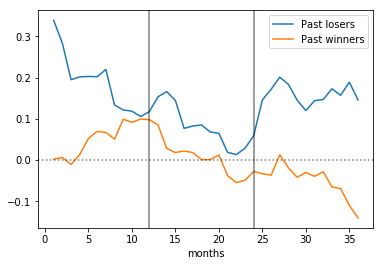

In [58]:
# Only post 1980
ax = bot_ptf_ret.set_index('date')['1980':].groupby('months')['exret'].mean().plot(label='Past losers')
top_ptf_ret.set_index('date')['1980':].groupby('months')['exret'].mean().plot(ax=ax, label='Past winners')
ax.legend()
ax.axhline(y=0, color='black', alpha=0.5, linestyle=':')
ax.axvline(x=12, color='black', alpha=0.5, linestyle='-')
ax.axvline(x=24, color='black', alpha=0.5, linestyle='-')

Exercise: check if the results chnage significantly if portfolio formation is not done in January.